In [1]:
!which python

/home/pshaburov/miniconda3/envs/nlp_env/bin/python


In [1]:
import typing as tp
import numpy as np
import pandas as pd
import os

from collections import defaultdict

from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

if device == 'cpu':
    print("Fine-tuning BERT without an accelerator is not party-approved.")

pd.set_option('display.max_colwidth', -1)  

/tmp/ipykernel_1422411/3172552474.py:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Part 1 ~ Download Dataset + Finetune Bert Model on MLM objective

In [4]:
!pip install -q transformers
!wget -q https://github.com/shentianxiao/language-style-transfer/raw/master/data/yelp/sentiment.train.0 -O train_negative
!wget -q https://github.com/shentianxiao/language-style-transfer/raw/master/data/yelp/sentiment.train.1 -O train_positive

In [5]:
!head -n 5 ./train_negative
!echo
!head -n 5 ./train_positive

i was sadly mistaken .
so on to the hoagies , the italian is general run of the mill .
minimal meat and a ton of shredded lettuce .
nothing really special & not worthy of the $ _num_ price tag .
second , the steak hoagie , it is atrocious .

excellent food .
superb customer service .
they also have daily specials and ice cream which is really good .
it 's a good toasted hoagie .
the staff is friendly .


### Helper Functions

In [2]:
def convergence_graph(loss_vals):
    print("min loss value", loss_vals[-1])

    plt.plot(range(1, len(loss_vals) +1 ), loss_vals, color ='blue')
    plt.rcParams["figure.figsize"] = (10,6)
    plt.grid()
    plt.xlabel("Number of iterations")
    plt.ylabel("cost (J)")
    plt.title("Convergence of gradient descent")

def apply_mask(example: tp.Dict[str, tp.Any], device='cuda:0', percent=0.15):
    
    # copy real input_ids:
    example['labels'] = example['input_ids'].detach().clone()
    
    # create random array of floats in equal dimension to input_ids
    rand = torch.rand(example['input_ids'].shape).to(device)

    # where the random array is less than 0.15, we set true
    mask_arr = rand < percent *  (example['input_ids'] != 101) * (example['input_ids'] != 102) * (example['input_ids'] != 0) 
    
    # create selection from mask_arr
    selection = mask_arr.nonzero().tolist()

    for i, j in selection:
        example['input_ids'][i][j] = 103
        
    return example


class PadSequence:
    def __init__(self, padded_columns, device='cuda:1'):
        self.padded_columns = set(padded_columns)
        self.device = device

    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, tensor in example.items():
                padded_batch[key].append(tensor)
            
        #print("done")       
        for key, val in padded_batch.items():
            #print(val)
            if key in self.padded_columns:
                padded_batch[key] = torch.nn.utils.rnn.pad_sequence(val, batch_first=True).to(self.device)
        return padded_batch
    

class Dataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, lines):
        self.tokenizer = tokenizer
        self.lines = lines
       
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.lines)

    def __getitem__(self, index):
        'Generates one sample of data'
        
        sample = self.tokenizer(self.lines[index])
        sample['input_ids'] = torch.as_tensor(sample['input_ids'])
        sample['token_type_ids'] = torch.tensor(sample['token_type_ids'])
        sample['attention_mask'] = torch.tensor(sample['attention_mask'])
        sample['text'] = self.lines[index]
        
        return sample
    

### Load Bert Model
- moving model to gpu

In [3]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

bert_mlm_positive = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True).to(device)

bert_mlm_negative = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model

### Dataset Preperation
- build Dataset Object
- build Dataloaders

In [4]:
with open('train_negative', encoding="utf-8") as f:
    negative_lines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]
    
with open('train_positive', encoding="utf-8") as f:
    positive_lines = [line for line in f.read().splitlines() if (len(line) > 0 and not line.isspace())]

negative_lines = negative_lines[:50000]
positive_lines = positive_lines[:50000]

print(len(negative_lines))
print(len(positive_lines))

# Get Datatset

negative_dataset = Dataset(tokenizer, negative_lines)
positive_dataset = Dataset(tokenizer, positive_lines)

# Get TrainLoaders

positive_loader = torch.utils.data.DataLoader(positive_dataset, 
                                               batch_size=32, 
                                               drop_last= True, 
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels'], device='cuda:0'
                                                                          ))

negative_loader = torch.utils.data.DataLoader(negative_dataset, 
                                              batch_size=32, 
                                              drop_last= True, 
                                              collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels'], device='cuda:0'
                                                                          ))

negative_batch = next(iter(negative_loader))
print(negative_batch['text'][5])

positive_batch = next(iter(positive_loader))
print(positive_batch['text'][3])

50000
50000
i had to pay $ _num_ to add cheese to the hoagie .
it 's a good toasted hoagie .


### Pretrain Bert on Masked language modeling (MLM) objective
- Attached below you can find training code that fine-tunes a BERT model for Masked Language Modeling

In [5]:
def pretrain_masked_lm(model, loader, num_epochs=10, device='cuda:0'):
    model.to(device)
    model.train() 
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    train_loss = []
    avg_batch_loss = []
    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        for batch in loader:
            batch = apply_mask(batch)
            outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'], 
                        labels=batch['labels'].long(), 
                        output_hidden_states=True,
                        return_dict=True
                       )
            loss = outputs.loss
            #print(loss)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            avg_batch_loss.append(loss.item())
        
        avg = sum(avg_batch_loss) / len(avg_batch_loss)
        train_loss.append(avg)
        
    return train_loss




  0%|                                                                                                                                | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1420320/2385670290.py:23: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  selection = mask_arr.nonzero().tolist()
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [19:52<00:00, 119.22s/it]


min loss value 0.14127627861532221


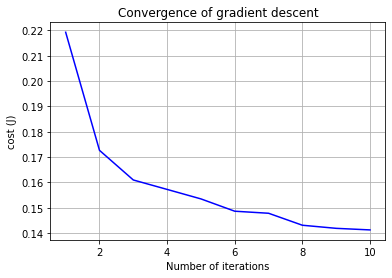

In [18]:
# <Build and train a MLM for correct opinions>

train_loss = pretrain_masked_lm(bert_mlm_positive, positive_loader)

torch.save(bert_mlm_positive.state_dict(), 'bert_positive.pth')

convergence_graph(train_loss) 

  0%|                                                                                                                                | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1422411/2385670290.py:23: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  selection = mask_arr.nonzero().tolist()
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [21:05<00:00, 126.51s/it]


min loss value 0.14769063119880294


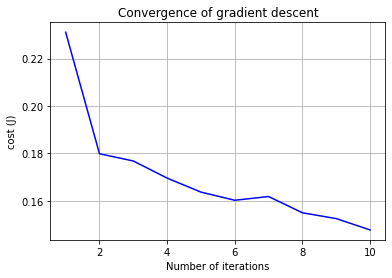

In [6]:
# <Build and train a MLM for incorrect opinions>

train_loss2 = pretrain_masked_lm(bert_mlm_negative, negative_loader, num_epochs=10)

torch.save(bert_mlm_negative.state_dict(), 'bert_negative.pth')

convergence_graph(train_loss2) 

### Load finetuned MLM Model from file

In [8]:
bert_mlm_positive = BertForMaskedLM.from_pretrained('bert-base-uncased', return_dict=True)

bert_mlm_positive.load_state_dict(torch.load('bert_positive.pth'))     

bert_mlm_positive.to(device)

print()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Part 2: Replace tokens

We can now use the two masked language models to align user opinions. We can do so with the following steps:

1. Find tokens where the ratio $(P_{positive}(x) + \epsilon) / (P_{negative}(x) + \epsilon)$ is the smallest
2. Replace those tokens with one of $k$ most likely tokens according to $P_{positive}(x)$.
3. Rinse, repeat

You can find the full procedure at https://arxiv.org/abs/2010.01054

In [9]:
from copy import deepcopy 
from transformers import pipeline
import random

def get_replacements(sentence: str, num_tokens, k_best, epsilon=1e-3, device='cuda:0'):
    
    bert_mlm_positive.to(device)
    bert_mlm_negative.to(device)
   
    bert_mlm_positive.eval()
    bert_mlm_negative.eval()
    
    """
    - split the sentence into tokens using the BERT tokenizer
    - find :num_tokens: tokens with the highest ratio (see above)
    - replace them with :k_best: words according to bert_mlm_positive
    :return: a list of all possible strings (up to k_best * num_tokens)
    """

    example = tokenizer(sentence, return_tensors='pt').to(device)
    sample_dict = {}
    for i in range(1, example['input_ids'].shape[1] - 1):
        masked_example = deepcopy(example)
        
        masked_example['input_ids'][0][i] = 103
        label = example['input_ids'][0][i].cpu()
        
        with torch.no_grad():
            positive_outputs = bert_mlm_positive(input_ids=masked_example['input_ids'],
                        attention_mask=masked_example['attention_mask'], 
                       ).logits.cpu()
            
            negative_outputs = bert_mlm_negative(input_ids=masked_example['input_ids'],
                                                 attention_mask=example['attention_mask'], 
                                                ).logits.cpu()
        
        #print("\n", tokenizer.decode(label))   
        positive_score = positive_outputs[0][i][label]
        
        negative_score = negative_outputs[0][i][label]
        
        score = (positive_score + epsilon) / (negative_score + epsilon)
        #print("score:", score, "\n")             
        sample_dict[label] = [score, i]
    
    
    score_dict = dict(sorted(sample_dict.items(), key=lambda item: item[1], reverse=False))  # sort dict
    #print(score_dict)
    
    token_dict = {}
    #token_list = list(score_dict)[: num_tokens]
    token_list = list(score_dict.items())[: num_tokens]
    
    with torch.no_grad():
        unmasker = pipeline('fill-mask', model=bert_mlm_positive.cpu(), tokenizer=tokenizer)
    
    #print(token_list)
    for token in token_list:
        modified = example['input_ids'].clone()
        #modified = torch.where(modified==token[0] ,torch.tensor(103).to(device),modified).cpu()
        modified[0][token[1][1]] = 103
        modified = list(modified[0])
        modified = tokenizer.decode(modified)
        new_sentences = unmasker(modified)[:k_best]
        for i in range(k_best):
            val_arr = []
            for i, val in enumerate(new_sentences):
                val_arr.append(val['token'])
            token_dict[token[0]] = val_arr
            
    #print(token_dict)
    
    modified = example['input_ids'].clone().cpu()
    for key in token_dict:
        elem = random.choice(token_dict[key])
        modified = torch.where(modified==key,torch.tensor(elem), modified).cpu()
    
    modified = list(modified[0])
    modified = tokenizer.decode(modified, skip_special_tokens=True) 
    
    return modified


get_replacements("food is bad and quite horrible.", 2, 3)


'food is good and quite delicious.'

In [16]:
get_replacements("the pizza has a bad taste", num_tokens=2, k_best=3)

'the pizza has a twist!'

In [18]:
get_replacements("I was very unhappy coming here", num_tokens=2, k_best=3)

'i was very enjoyed working here'